# Actor Critic

## Value based

\begin{equation} V_\theta(s) \approx V^\pi(s) \end{equation}
\begin{equation} Q_\theta(s, a) \approx Q^\pi(s, a) \end{equation}

We attemp to learn a value or action-value function given a specific policy. We use MC, TD... methods to estimate the target values. We imporve the policy by selecting the action in an $\epsilon$ - greedy fashion.

## Policy based

\begin{equation} \pi_\theta (s, a) = P[a | s, \theta] \end{equation}

We model a policy directly. 

Here we can again use a value function for optimization which can be written (in one step case) as:


\begin{equation} J(\theta) = \mathop{\mathbb{E}}_{\pi_\theta}[r] \end{equation}

Which can be expanded as:

\begin{equation} J(\theta) = \sum_s d(s) \sum_a \pi_\theta R_{s,a} \end{equation}

where d(s) is a stationary distribution of the MDP.

The gradient of the objective function can be writtern as:

\begin{equation} \nabla J(\theta) = \mathop{\mathbb{E}}_{\pi_\theta}[\nabla_\theta log\pi_\theta(s, a) \cdot r] \end{equation}

Thus, we can again use MC, TD... methods to estimate this gradient!

## Policy Gradient Theorem

Theorem: In case of multi-step MDPs, for anny differentiable policy $\pi_\theta(s, a)$, the policy gradient is:

\begin{equation}
\nabla_\theta J(\theta)
=
\mathop{\mathbb{E}}_{\pi_\theta}[\nabla_\theta log\pi_\theta(s, a) \cdot Q^{\pi_\theta}(s, a)]
\end{equation}

Simple MC algorithm:

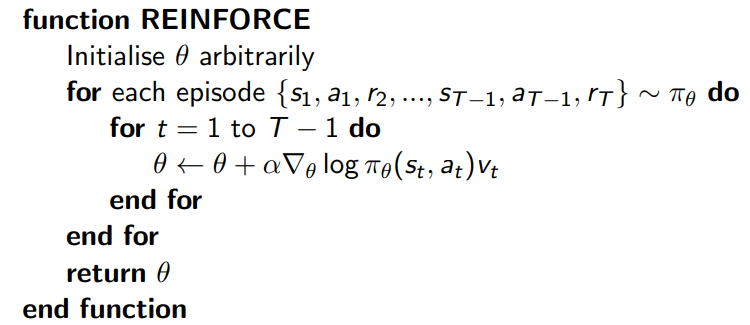


### The main problem is that the estimate of Q is very high variance!

#### Tip: Usually you should choose $\pi$ to be a Gaussian and model your $\mu$, while $\sigma$ can be modelled or parametrised. 

## Continous CartPole with modelled $\mu$ and decaying $\sigma$

In this case the log of the policy reduces to $ -\frac{(a - \mu(s))^2}{2 \sigma^2} $. So finally the loss function can be written as the mean-squared error of the choosen action with respect to the mean divided by the variance.
The environment code is taken from:  https://gist.github.com/iandanforth/e3ffb67cf3623153e968f2afdfb01dc8

In [10]:
from continuous_cart_pole_env import ContinuousCartPoleEnv

In [97]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym 

In [61]:
env_name = 'ContinuousCartPoleEnv'
#env = gym.make(env_name)
env = ContinuousCartPoleEnv()

print(env.action_space.shape)
print(env.observation_space.shape)
print(env.action_space.low, env.action_space.high)

(1,)
(4,)
[-1.] [1.]


In [28]:
# Test

state = env.reset()
done = False
while not done:
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.1)
env.close()

In [138]:
class Policy(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [139]:
def get_action(state, model, sigma):
    state = torch.tensor(state, dtype=torch.float32)
    mu = model(state).item()
    action = np.random.normal(mu, sigma, 1)[0]
    action = max(action, -1)
    action = min(action, 1)
    
    # MUST BE CASTED AS np.array([action])
    return action

In [157]:
def play_optimally(model, render = False):
    total_reward = 0
    done = False
    state = env.reset()
    
    while done is not True:
        action = model(torch.tensor(state, dtype=torch.float32)).item()
        state, reward, done, info = env.step(np.array([action]))
        total_reward += reward
        
        if render is True:
            env.render()
            time.sleep(0.1)
    
    print('The total reward is:', total_reward)
    env.close()

In [158]:
play_optimally(model, render=True)

AttributeError: 'NoneType' object has no attribute 'set_current'

In [140]:
model = Policy(4,1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
n_episode = 500
sigma_max = 0.5
sigma_min = 0.05
rewards = []
running_loss = []

for i_episode in range(n_episode):
    
    sigma = max(sigma_max * ( 1 - i_episode / n_episode), sigma_min)
    
    
    state = env.reset()
    done = False
    history = []
    total_reward = 0
    
    # Play the episode
    while done is not True:
        with torch.no_grad():
            action = get_action(state, model, sigma)
        
        next_state, reward, done, info = env.step(np.array([action]))
        
        history.append([state, action, reward])
        
        total_reward += reward
        state = next_state
    rewards.append(total_reward)
    
    # Compute the action-value function
    # Essentially cumulative rewards looked from behind
    for i in range(len(history) - 2, - 1, -1):
        history[i][2] += history[i+1][2]
    
    for state, action, Q in history:
        mu = model(torch.tensor(state, dtype=torch.float32))
        
        optimizer.zero_grad()
        loss = Q * criterion(torch.tensor(action, dtype=torch.float32), mu)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
        

C:\Users\vuk11\miniconda3\envs\Torch\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


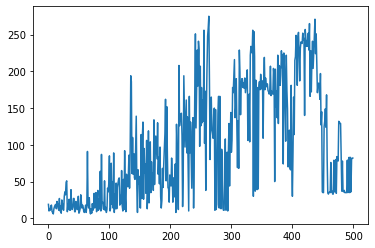

In [145]:
plt.plot(rewards)

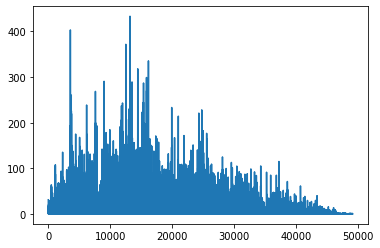

In [146]:
plt.plot(running_loss)